# SOL/USD State Matrix - Exploratory Data Analysis

**Asset:** SOL/USD | **Timeframe:** 15-minute candles | **Source:** Binance

---

### Purpose

This notebook validates and profiles the **state matrix** - a pre-computed parquet file that enriches raw OHLCV price data with three regime dimensions and triple-barrier labels. The state matrix is the single source of truth for all downstream pipeline components (backtesting, strategy generation, diagnostics).

### What is the State Matrix?

Each 15-minute candle is tagged with:

| Column | Values | How it's computed |
|--------|--------|-------------------|
| `session` | ASIA, LONDON, NY, OTHER | UTC hour of the candle (ASIA 00-07, LONDON 08-12, NY 13-20, OTHER 21-23) |
| `trend_regime` | UPTREND, DOWNTREND, CONSOLIDATION | SMA(50) slope over 3 bars, threshold of +/-0.0005 |
| `vol_regime` | HIGH_VOL, LOW_VOL | ATR(24) vs its own SMA(20) - above = HIGH_VOL, at/below = LOW_VOL |
| `tbm_label` | +1, -1, 0, NaN | Triple-barrier method oracle label (see Section D) |

These three regime dimensions create **4 x 3 x 2 = 24 micro-buckets**. The goal of this EDA is to understand which buckets carry a directional edge worth exploiting.

### Notebook Structure

- **A. Setup** - Load data, validate schema and index
- **B. Data Quality** - Missingness, sentinel values, numeric distributions
- **C. Regime Coverage** - How candles distribute across regime buckets (1D, 2D, 3D)
- **D. Regime Edge** - Triple-barrier label composition per bucket (bias, actionability)
- **E. Temporal Drift** - Whether regime distributions and edges are stable month-over-month
- **F. Validation** - Automated consistency checks

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio

pio.renderers.default = "plotly_mimetype+png"

pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 180)

INPUT_PATH = "../data/state_matrix.parquet"
EXPECTED_FREQ = "15min"
REQUIRED_COLUMNS = [
    "open", "high", "low", "close", "volume",
    "session", "trend_regime", "vol_regime", "tbm_label"
]

SESSION_ORDER = ["ASIA", "LONDON", "NY", "OTHER"]
TREND_ORDER = ["UPTREND", "DOWNTREND", "CONSOLIDATION"]
VOL_ORDER = ["HIGH_VOL", "LOW_VOL"]

In [2]:
def validate_state_matrix(df: pd.DataFrame) -> dict:
    missing_cols = [c for c in REQUIRED_COLUMNS if c not in df.columns]
    if missing_cols:
        raise ValueError(f"Missing required columns: {missing_cols}")

    if not isinstance(df.index, pd.DatetimeIndex):
        raise TypeError("Index must be a pandas DatetimeIndex.")

    if not df.index.is_monotonic_increasing:
        raise ValueError("Index must be sorted ascending (monotonic increasing).")

    if df.index.has_duplicates:
        raise ValueError("Index contains duplicate timestamps; expected unique 15m bars.")

    allowed_labels = {-1.0, 0.0, 1.0}
    label_values = set(pd.Series(df["tbm_label"].dropna().unique()).astype(float).tolist())
    invalid_labels = sorted(v for v in label_values if v not in allowed_labels)
    if invalid_labels:
        raise ValueError(f"Invalid tbm_label values found: {invalid_labels}")

    return {
        "rows": len(df),
        "start": df.index.min(),
        "end": df.index.max(),
        "n_missing_labels": int(df["tbm_label"].isna().sum()),
    }


def _bucket_orders_for_dims(dims: list[str]) -> dict[str, list[str]]:
    order_map = {
        "session": SESSION_ORDER,
        "trend_regime": TREND_ORDER,
        "vol_regime": VOL_ORDER,
    }
    return {d: order_map[d] for d in dims if d in order_map}


def _expand_bucket_grid(df: pd.DataFrame, dims: list[str]) -> pd.DataFrame:
    """Return full cartesian grid for known regime dims so zero-count buckets are explicit."""
    if not dims:
        return pd.DataFrame({"bucket_key": ["GLOBAL"], "bucket_level": ["GLOBAL"]})

    orders = _bucket_orders_for_dims(dims)
    levels = []
    for d in dims:
        if d in orders:
            levels.append(orders[d])
        else:
            levels.append(sorted(df[d].astype(str).dropna().unique().tolist()))

    grid = pd.MultiIndex.from_product(levels, names=dims).to_frame(index=False)
    grid["bucket_key"] = grid[dims].astype(str).agg("|".join, axis=1)
    grid["bucket_level"] = f"{len(dims)}D"
    return grid


def bucket_key_from_dims(df: pd.DataFrame, dims: list[str]) -> pd.Series:
    if len(dims) == 0:
        return pd.Series(["GLOBAL"] * len(df), index=df.index)
    return df[dims].astype(str).agg("|".join, axis=1)


def coverage_table(df: pd.DataFrame, dims: list[str]) -> pd.DataFrame:
    total = len(df)
    if total == 0:
        raise ValueError("DataFrame is empty; cannot compute coverage.")

    if not dims:
        return pd.DataFrame({
            "count": [total],
            "coverage_pct": [100.0],
            "bucket_key": ["GLOBAL"],
            "bucket_level": ["GLOBAL"],
        })

    grouped = df.groupby(dims, dropna=False).size().rename("count").reset_index()
    grouped["coverage_pct"] = grouped["count"] / total * 100.0
    grouped["bucket_key"] = grouped[dims].astype(str).agg("|".join, axis=1)
    grouped["bucket_level"] = f"{len(dims)}D"

    # Ensure all expected regime combinations are present with zero count.
    grid = _expand_bucket_grid(df, dims)
    out = grid.merge(grouped, on=dims + ["bucket_key", "bucket_level"], how="left")
    out["count"] = out["count"].fillna(0).astype(int)
    out["coverage_pct"] = out["coverage_pct"].fillna(0.0)
    return out


def label_profile(df: pd.DataFrame, dims: list[str]) -> pd.DataFrame:
    base = coverage_table(df, dims)

    if not dims:
        p_plus = float((df["tbm_label"] == 1).mean())
        p_minus = float((df["tbm_label"] == -1).mean())
        p_zero = float((df["tbm_label"] == 0).mean())
        p_nan = float(df["tbm_label"].isna().mean())
        out = base.copy()
        out["p_plus"] = p_plus
        out["p_minus"] = p_minus
        out["p_zero"] = p_zero
        out["p_nan"] = p_nan
    else:
        grouped = df.groupby(dims, dropna=False)["tbm_label"]
        p_plus = grouped.apply(lambda s: (s == 1).mean()).reset_index(name="p_plus")
        p_minus = grouped.apply(lambda s: (s == -1).mean()).reset_index(name="p_minus")
        p_zero = grouped.apply(lambda s: (s == 0).mean()).reset_index(name="p_zero")
        p_nan = grouped.apply(lambda s: s.isna().mean()).reset_index(name="p_nan")

        out = base.merge(p_plus, on=dims, how="left")
        out = out.merge(p_minus, on=dims, how="left")
        out = out.merge(p_zero, on=dims, how="left")
        out = out.merge(p_nan, on=dims, how="left")
        out[["p_plus", "p_minus", "p_zero", "p_nan"]] = out[["p_plus", "p_minus", "p_zero", "p_nan"]].fillna(0.0)

    out["bias"] = out["p_plus"] - out["p_minus"]
    out["actionability"] = 1.0 - out["p_zero"] - out["p_nan"]
    out["prob_sum"] = out[["p_plus", "p_minus", "p_zero", "p_nan"]].sum(axis=1)
    return out


def monthly_regime_drift(df: pd.DataFrame, col: str) -> pd.DataFrame:
    tmp = df.copy()
    tmp["month"] = tmp.index.to_period("M").astype(str)
    g = tmp.groupby(["month", col], dropna=False).size().rename("count").reset_index()
    g["pct"] = g["count"] / g.groupby("month")["count"].transform("sum") * 100.0
    return g


def build_findings_table(profile_1d: pd.DataFrame, profile_2d: pd.DataFrame, profile_3d: pd.DataFrame, low_count_threshold: int) -> pd.DataFrame:
    combined = pd.concat([profile_1d, profile_2d, profile_3d], ignore_index=True)
    combined["low_count_flag"] = combined["count"] < low_count_threshold

    comments = []
    for _, r in combined.iterrows():
        if r["low_count_flag"]:
            comments.append("Uncertain: low sample bucket; interpret cautiously.")
        elif abs(r["bias"]) >= 0.08 and r["actionability"] >= 0.50 and r["coverage_pct"] >= 3:
            comments.append("Good candidate regime: directional edge with usable actionability.")
        elif r["actionability"] < 0.25:
            comments.append("Avoid/uncertain: mostly timeout/whipsaw behavior.")
        elif abs(r["bias"]) < 0.02:
            comments.append("Neutral edge: weak directional skew.")
        else:
            comments.append("Potentially useful; validate with strategy-specific tests.")

    combined["comment"] = comments
    cols = [
        "bucket_level", "bucket_key", "count", "coverage_pct", "bias", "actionability",
        "p_plus", "p_minus", "p_zero", "p_nan", "low_count_flag", "comment"
    ]
    out = combined[cols].copy()

    level_order = {"1D": 1, "2D": 2, "3D": 3, "GLOBAL": 0}
    out["_level_sort"] = out["bucket_level"].map(level_order).fillna(99)
    out = out.sort_values(["_level_sort", "coverage_pct", "bias"], ascending=[True, False, False]).drop(columns=["_level_sort"]) \
             .reset_index(drop=True)
    return out


---

## A. Setup and Data Contract

Load the state matrix and run structural validation:
- All required columns present (`open/high/low/close/volume` + regime tags + `tbm_label`)
- Index is a UTC DatetimeIndex, sorted ascending, with no duplicates
- `tbm_label` values are restricted to {-1.0, 0.0, 1.0, NaN}
- Timestamp grid is a continuous 15-minute sequence with no gaps or extras

In [3]:
sol = pd.read_parquet(INPUT_PATH)

if not isinstance(sol.index, pd.DatetimeIndex):
    sol.index = pd.to_datetime(sol.index, utc=True, errors="coerce")

sol = sol.sort_index()
validation = validate_state_matrix(sol)
validation


{'rows': 105116,
 'start': Timestamp('2023-02-22 19:00:00+0000', tz='UTC'),
 'end': Timestamp('2026-02-21 19:00:00+0000', tz='UTC'),
 'n_missing_labels': 122}

In [4]:
expected_index = pd.date_range(sol.index.min(), sol.index.max(), freq=EXPECTED_FREQ)
missing_timestamps = expected_index.difference(sol.index)
extra_timestamps = sol.index.difference(expected_index)

print(f"Rows: {len(sol):,}")
print(f"Start: {sol.index.min()}")
print(f"End:   {sol.index.max()}")
print(f"Missing timestamps vs expected 15m grid: {len(missing_timestamps):,}")
print(f"Extra timestamps outside expected grid: {len(extra_timestamps):,}")

years_present = sorted(sol.index.year.unique().tolist())
print(f"Years present: {years_present}")
if years_present == [2025]:
    print("Note: dataset currently spans only 2025. Findings may not generalize across 2023-2025.")


Rows: 105,116
Start: 2023-02-22 19:00:00+00:00
End:   2026-02-21 19:00:00+00:00
Missing timestamps vs expected 15m grid: 5
Extra timestamps outside expected grid: 0
Years present: [2023, 2024, 2025, 2026]


---

## B. Data Quality Snapshot

Before analyzing regimes, we need to understand the health of the underlying data:

- **Missingness** - Which columns have nulls, and at what rate? High null rates in `tbm_label` may indicate whipsaw candles where both long and short barriers were hit simultaneously.
- **TBM sentinel values** - The triple-barrier labeling uses `-1` as a sentinel for exit index/duration when a candle could not be evaluated (e.g., near the end of the dataset where the forward window runs out). These are expected but must be quantified.
- **Numeric distributions** - Descriptive stats for OHLCV and TBM outputs, including IQR-based outlier bounds to flag anomalies in price, volume, PnL, or trade duration.

In [5]:
missing_tbl = pd.DataFrame({
    "null_count": sol.isna().sum(),
    "null_pct": sol.isna().mean() * 100,
}).sort_values("null_pct", ascending=False)

tbm_edge_checks = {
    "tbm_long_exit_idx == -1": int((sol.get("tbm_long_exit_idx", pd.Series([], dtype=float)) == -1).sum()) if "tbm_long_exit_idx" in sol.columns else None,
    "tbm_short_exit_idx == -1": int((sol.get("tbm_short_exit_idx", pd.Series([], dtype=float)) == -1).sum()) if "tbm_short_exit_idx" in sol.columns else None,
    "tbm_long_duration == -1": int((sol.get("tbm_long_duration", pd.Series([], dtype=float)) == -1).sum()) if "tbm_long_duration" in sol.columns else None,
    "tbm_short_duration == -1": int((sol.get("tbm_short_duration", pd.Series([], dtype=float)) == -1).sum()) if "tbm_short_duration" in sol.columns else None,
    "tbm_label is NaN": int(sol["tbm_label"].isna().sum()),
}

missing_tbl.head(20), tbm_edge_checks


(                    null_count  null_pct
 tbm_label                  122  0.116062
 tbm_long_pnl                24  0.022832
 tbm_short_pnl               24  0.022832
 open                         0  0.000000
 high                         0  0.000000
 low                          0  0.000000
 count                        0  0.000000
 close                        0  0.000000
 volume                       0  0.000000
 quote_volume                 0  0.000000
 trend_regime                 0  0.000000
 session                      0  0.000000
 taker_buy_volume             0  0.000000
 vol_regime                   0  0.000000
 tbm_long_exit_idx            0  0.000000
 tbm_long_duration            0  0.000000
 tbm_short_exit_idx           0  0.000000
 tbm_short_duration           0  0.000000,
 {'tbm_long_exit_idx == -1': 24,
  'tbm_short_exit_idx == -1': 24,
  'tbm_long_duration == -1': 24,
  'tbm_short_duration == -1': 24,
  'tbm_label is NaN': 122})

In [6]:
if "pd" not in globals() or "sol" not in globals():
    raise RuntimeError("Run setup/data-load cells first (imports + `sol`).")

numeric_cols = [c for c in [
    "open", "high", "low", "close", "volume",
    "tbm_label", "tbm_long_pnl", "tbm_short_pnl",
    "tbm_long_duration", "tbm_short_duration"
] if c in sol.columns]

if not numeric_cols:
    raise ValueError("No numeric columns found for summary.")

summary = sol[numeric_cols].describe(percentiles=[0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99]).T

# Robust quantile references in case pandas display labels vary by version
q25_col = "25%" if "25%" in summary.columns else None
q75_col = "75%" if "75%" in summary.columns else None
if q25_col is None or q75_col is None:
    q25 = sol[numeric_cols].quantile(0.25)
    q75 = sol[numeric_cols].quantile(0.75)
else:
    q25 = summary[q25_col]
    q75 = summary[q75_col]

summary["iqr"] = q75 - q25
summary["outlier_low"] = q25 - 1.5 * summary["iqr"]
summary["outlier_high"] = q75 + 1.5 * summary["iqr"]
summary


,count,mean,std,min,1%,5%,25%,50%,75%,95%,99%,max,iqr,outlier_low,outlier_high
open,105116.0,122.775709,67.495773,13.680000,16.100000,19.520000,58.420000,138.600000,171.740000,225.572500,247.487000,2.946900e+02,113.320000,-111.560000,341.720000
high,105116.0,123.170702,67.707888,14.120000,16.150000,19.550000,58.650000,139.050000,172.212500,226.320000,248.450000,2.958300e+02,113.562500,-111.693750,342.556250
low,105116.0,122.365751,67.272228,12.800000,16.060000,19.470000,58.180000,138.150000,171.190000,224.830000,246.550000,2.903600e+02,113.010000,-111.335000,340.705000
close,105116.0,122.776326,67.495266,13.690000,16.100000,19.520000,58.420000,138.600000,171.740000,225.570000,247.495500,2.946900e+02,113.320000,-111.560000,341.720000
volume,105116.0,46694.602849,58236.045965,0.000000,4891.326500,8173.714500,17025.979500,29342.602500,54262.480250,138688.232500,277018.098600,1.856234e+06,37236.500750,-38828.771625,110117.231375
tbm_label,104994.0,-0.011239,0.755732,-1.000000,-1.000000,-1.000000,-1.000000,0.000000,1.000000,1.000000,1.000000,1.000000e+00,2.000000,-4.000000,4.000000
tbm_long_pnl,105092.0,-0.000027,0.014419,-0.058938,-0.024071,-0.016372,-0.009394,-0.006047,0.011614,0.025822,0.040622,1.360792e-01,0.021009,-0.040907,0.043127
tbm_short_pnl,105092.0,-0.000066,0.014244,-0.068040,-0.024726,-0.016677,-0.009447,-0.005951,0.011743,0.024932,0.038984,9.755892e-02,0.021190,-0.041231,0.043528
tbm_long_duration,105116.0,12.132111,9.872248,-1.000000,1.000000,2.000000,4.000000,9.000000,18.000000,32.000000,32.000000,3.200000e+01,14.000000,-17.000000,39.000000
tbm_short_duration,105116.0,12.252825,9.854366,-1.000000,1.000000,2.000000,4.000000,9.000000,18.000000,32.000000,32.000000,3.200000e+01,14.000000,-17.000000,39.000000


---

## C. Regime Coverage

Coverage measures what percentage of total candles fall into each regime bucket. This matters because:

- **Imbalanced coverage** means some regime combinations are rare and statistically unreliable
- **Zero-count buckets** would indicate regime combinations that never occur in practice
- We analyze coverage at three levels of granularity:
  - **1D** - Each dimension independently (session, trend, volatility)
  - **2D** - Pairwise combinations (session x trend, session x vol, trend x vol)
  - **3D** - Full cross: all 24 micro-buckets (session x trend x vol)

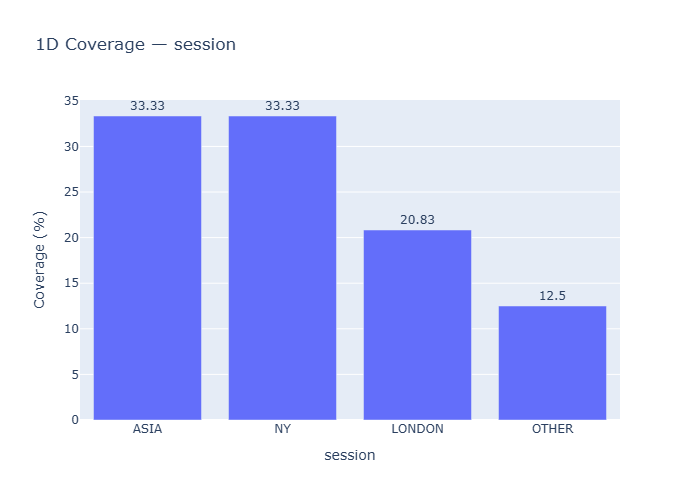

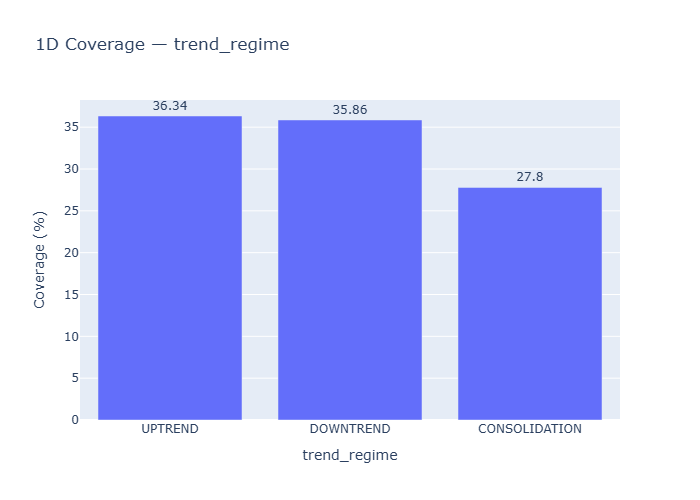

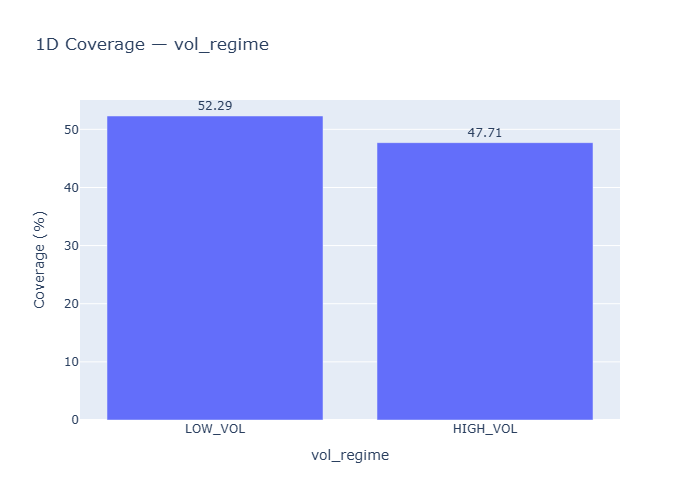

(  session bucket_key bucket_level  count  coverage_pct
 0    ASIA       ASIA           1D  35040     33.334602
 1  LONDON     LONDON           1D  21899     20.833175
 2      NY         NY           1D  35037     33.331748
 3   OTHER      OTHER           1D  13140     12.500476,
     trend_regime     bucket_key bucket_level  count  coverage_pct
 0        UPTREND        UPTREND           1D  38195     36.336048
 1      DOWNTREND      DOWNTREND           1D  37698     35.863237
 2  CONSOLIDATION  CONSOLIDATION           1D  29223     27.800715,
   vol_regime bucket_key bucket_level  count  coverage_pct
 0   HIGH_VOL   HIGH_VOL           1D  50147     47.706343
 1    LOW_VOL    LOW_VOL           1D  54969     52.293657)

In [7]:
if "px" not in globals():
    import plotly.express as px
if "coverage_table" not in globals() or "sol" not in globals():
    raise RuntimeError("Run setup/helper cells first (coverage_table + sol).")

cov_1d = {
    "session": coverage_table(sol, ["session"]),
    "trend_regime": coverage_table(sol, ["trend_regime"]),
    "vol_regime": coverage_table(sol, ["vol_regime"]),
}

for key, tbl in cov_1d.items():
    plot_tbl = tbl.sort_values("coverage_pct", ascending=False).copy()
    fig = px.bar(
        plot_tbl,
        x=key,
        y="coverage_pct",
        text=plot_tbl["coverage_pct"].round(2),
        title=f"1D Coverage — {key}",
    )
    fig.update_traces(textposition="outside")
    fig.update_layout(yaxis_title="Coverage (%)", xaxis_title=key, showlegend=False)
    fig.show()

cov_1d["session"], cov_1d["trend_regime"], cov_1d["vol_regime"]


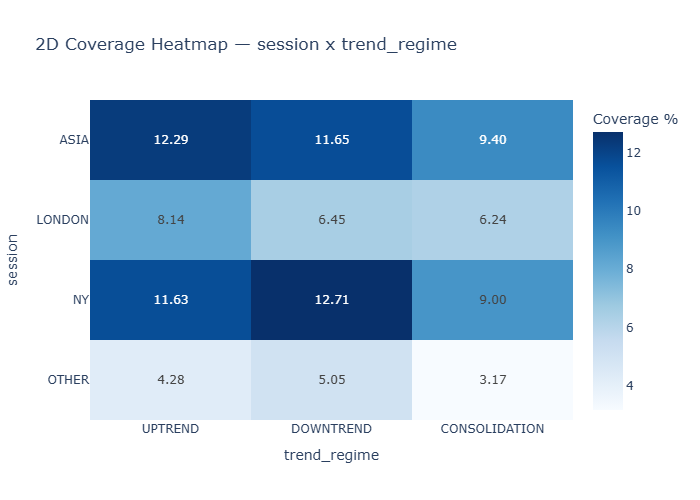

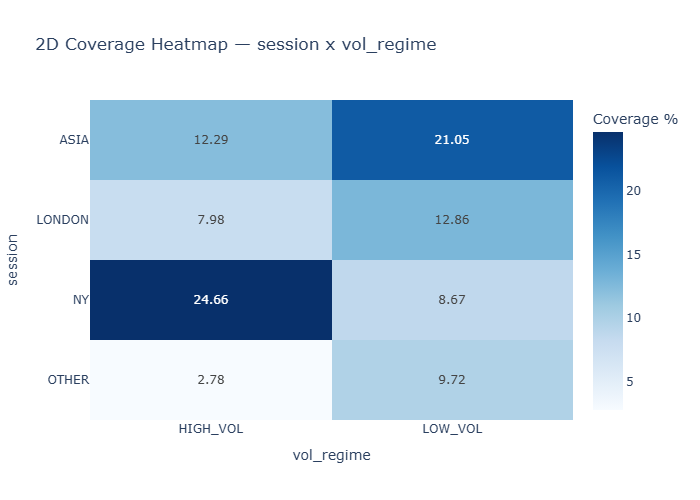

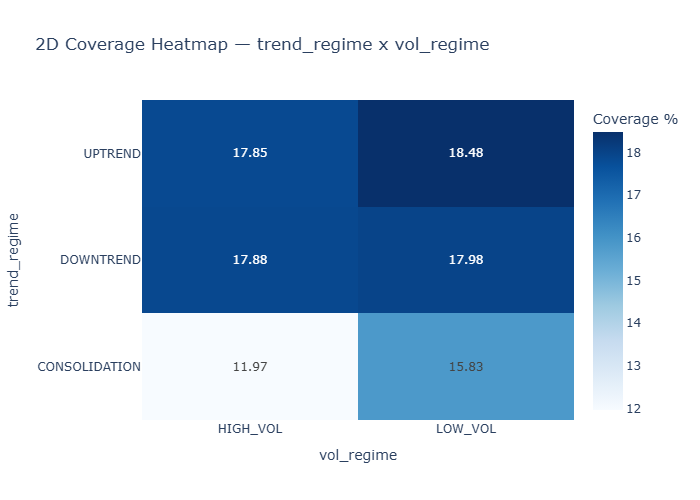

In [8]:
if "px" not in globals():
    import plotly.express as px
if "coverage_table" not in globals() or "sol" not in globals():
    raise RuntimeError("Run setup/helper cells first (coverage_table + sol).")

pairs = [
    ("session", "trend_regime"),
    ("session", "vol_regime"),
    ("trend_regime", "vol_regime"),
]

order_map = {
    "session": SESSION_ORDER,
    "trend_regime": TREND_ORDER,
    "vol_regime": VOL_ORDER,
}

for a, b in pairs:
    tbl = coverage_table(sol, [a, b])
    pivot = tbl.pivot(index=a, columns=b, values="coverage_pct").reindex(
        index=order_map.get(a, sorted(tbl[a].dropna().unique())),
        columns=order_map.get(b, sorted(tbl[b].dropna().unique())),
    ).fillna(0)

    fig = px.imshow(
        pivot,
        text_auto=".2f",
        color_continuous_scale="Blues",
        aspect="auto",
        title=f"2D Coverage Heatmap — {a} x {b}",
    )
    fig.update_layout(coloraxis_colorbar_title="Coverage %")
    fig.show()


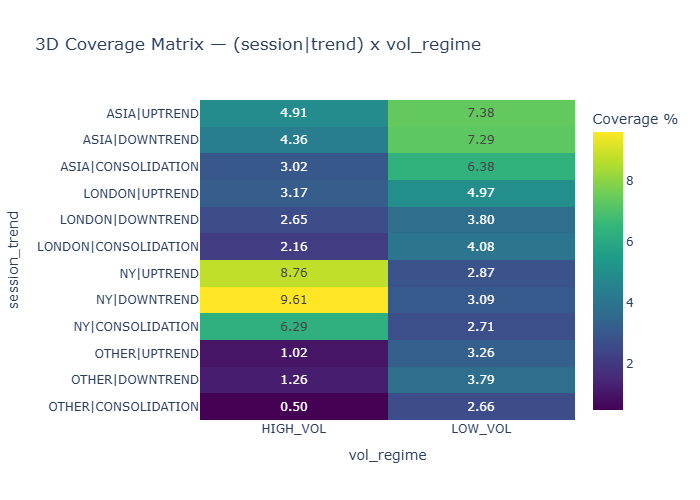

,session,trend_regime,vol_regime,bucket_key,bucket_level,count,coverage_pct,session_trend
0,NY,DOWNTREND,HIGH_VOL,NY|DOWNTREND|HIGH_VOL,3D,10104,9.612238,NY|DOWNTREND
1,NY,UPTREND,HIGH_VOL,NY|UPTREND|HIGH_VOL,3D,9209,8.760798,NY|UPTREND
2,ASIA,UPTREND,LOW_VOL,ASIA|UPTREND|LOW_VOL,3D,7762,7.384223,ASIA|UPTREND
3,ASIA,DOWNTREND,LOW_VOL,ASIA|DOWNTREND|LOW_VOL,3D,7660,7.287187,ASIA|DOWNTREND
4,ASIA,CONSOLIDATION,LOW_VOL,ASIA|CONSOLIDATION|LOW_VOL,3D,6702,6.375813,ASIA|CONSOLIDATION
5,NY,CONSOLIDATION,HIGH_VOL,NY|CONSOLIDATION|HIGH_VOL,3D,6611,6.289242,NY|CONSOLIDATION
6,LONDON,UPTREND,LOW_VOL,LONDON|UPTREND|LOW_VOL,3D,5222,4.967845,LONDON|UPTREND
7,ASIA,UPTREND,HIGH_VOL,ASIA|UPTREND|HIGH_VOL,3D,5156,4.905057,ASIA|UPTREND
8,ASIA,DOWNTREND,HIGH_VOL,ASIA|DOWNTREND|HIGH_VOL,3D,4583,4.359945,ASIA|DOWNTREND
9,LONDON,CONSOLIDATION,LOW_VOL,LONDON|CONSOLIDATION|LOW_VOL,3D,4293,4.084060,LONDON|CONSOLIDATION


In [9]:
if "px" not in globals():
    import plotly.express as px
if "coverage_table" not in globals() or "sol" not in globals():
    raise RuntimeError("Run setup/helper cells first (coverage_table + sol).")

cov_3d = coverage_table(sol, ["session", "trend_regime", "vol_regime"])
cov_3d["session_trend"] = cov_3d["session"] + "|" + cov_3d["trend_regime"]

row_order = [f"{s}|{t}" for s in SESSION_ORDER for t in TREND_ORDER]
heat_3d = cov_3d.pivot(index="session_trend", columns="vol_regime", values="coverage_pct").reindex(
    index=row_order,
    columns=VOL_ORDER,
).fillna(0)

fig = px.imshow(
    heat_3d,
    text_auto=".2f",
    color_continuous_scale="Viridis",
    aspect="auto",
    title="3D Coverage Matrix — (session|trend) x vol_regime",
)
fig.update_layout(coloraxis_colorbar_title="Coverage %")
fig.show()

cov_3d.sort_values("coverage_pct", ascending=False).reset_index(drop=True)


---

## D. Regime Edge (TBM Labels)

The **triple-barrier method (TBM)** evaluates every candle by simultaneously simulating a long and short trade with:
- **Take profit** at entry +/- 2.0x ATR
- **Stop loss** at entry -/+ 1.0x ATR
- **Timeout** after 50 bars (~12.5 hours) if neither barrier is hit

The oracle label assigned to each candle:
| Label | Meaning |
|-------|---------|
| **+1** | Long trade would have hit TP before SL |
| **-1** | Short trade would have hit TP before SL |
| **0** | Both sides timed out - no clear directional move |
| **NaN** | Whipsaw - both long and short hit their stop losses |

For each regime bucket, we compute:
- **`bias`** = P(+1) - P(-1) - positive means the bucket favors longs, negative favors shorts
- **`actionability`** = 1 - P(0) - P(NaN) - how often the bucket produces a clear directional outcome vs timeouts/whipsaws

A good candidate regime has **high |bias|**, **high actionability**, and **sufficient coverage** (sample size).

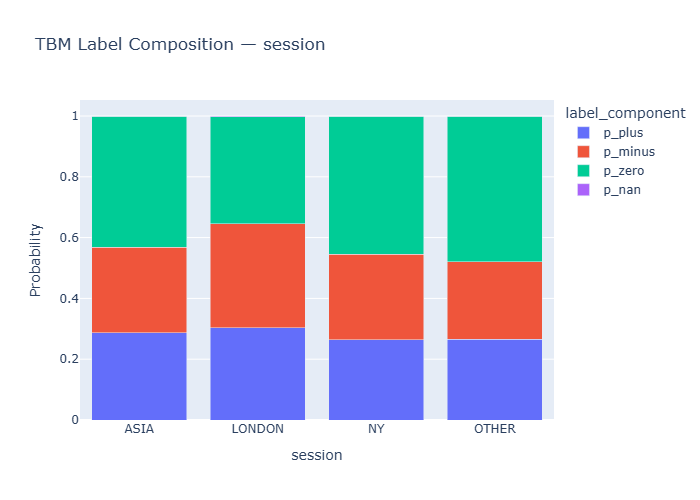

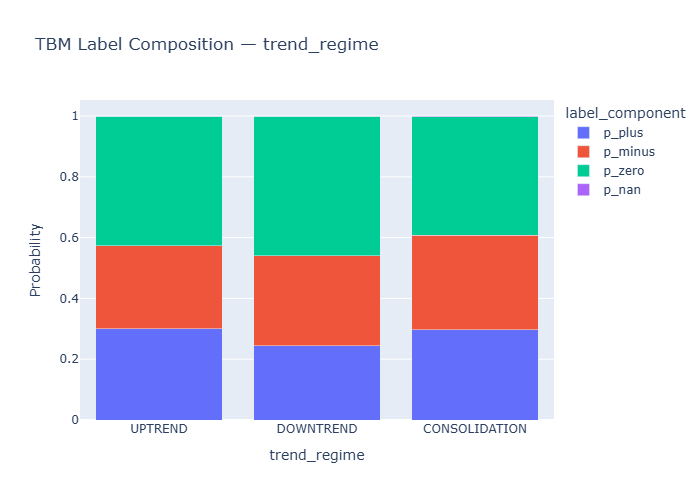

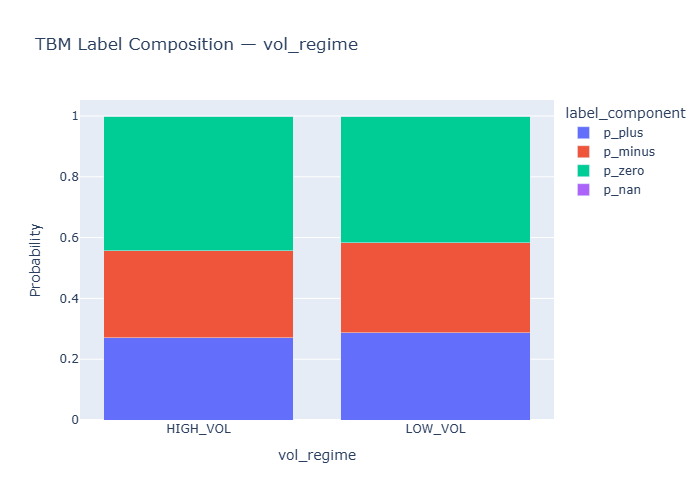

In [10]:
if "px" not in globals():
    import plotly.express as px
required = ["label_profile", "pairs", "sol"]
missing = [x for x in required if x not in globals()]
if missing:
    raise RuntimeError(f"Run prerequisite cells first. Missing: {missing}")

profile_1d = {
    "session": label_profile(sol, ["session"]),
    "trend_regime": label_profile(sol, ["trend_regime"]),
    "vol_regime": label_profile(sol, ["vol_regime"]),
}
profile_2d = {f"{a}__{b}": label_profile(sol, [a, b]) for a, b in pairs}
profile_3d = label_profile(sol, ["session", "trend_regime", "vol_regime"])

for key, tbl in profile_1d.items():
    melt = tbl[[key, "p_plus", "p_minus", "p_zero", "p_nan"]].melt(
        id_vars=[key], var_name="label_component", value_name="probability"
    )
    fig = px.bar(
        melt,
        x=key,
        y="probability",
        color="label_component",
        barmode="stack",
        title=f"TBM Label Composition — {key}",
    )
    fig.update_layout(yaxis_title="Probability")
    fig.show()


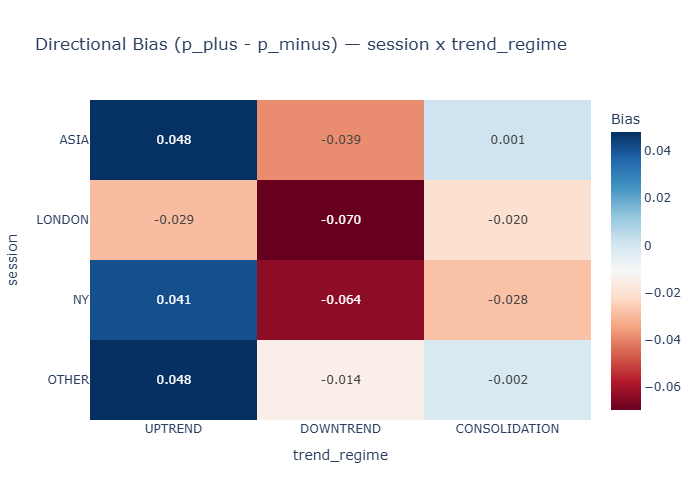

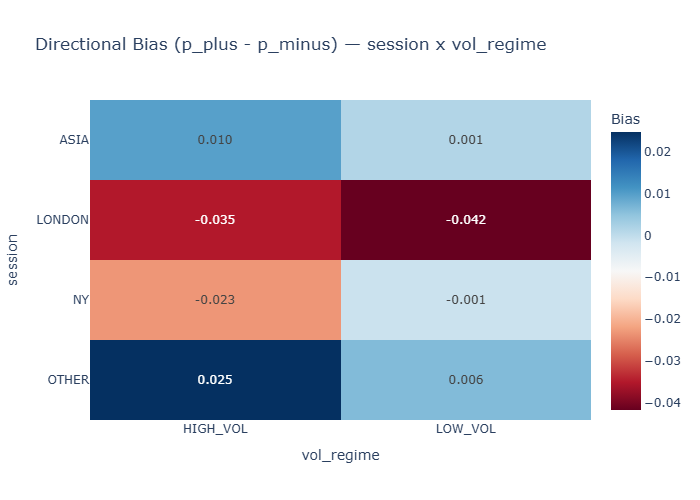

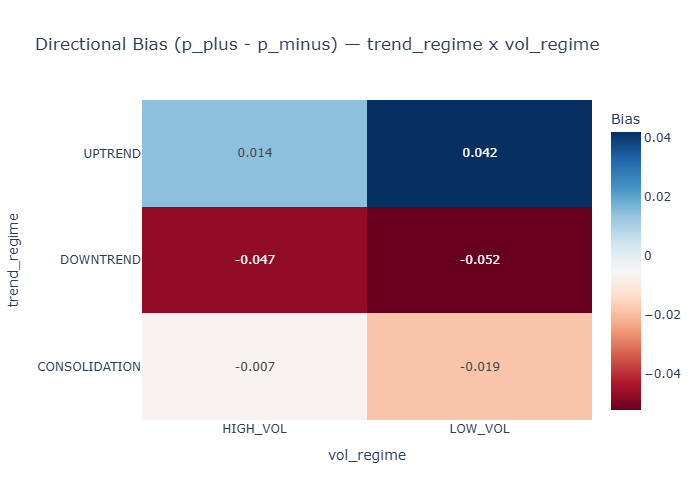

,bucket_key,count,coverage_pct,bias,actionability,p_plus,p_minus,p_zero,p_nan
9,LONDON|DOWNTREND|LOW_VOL,3998,3.803417,-0.088794,0.640070,0.275638,0.364432,0.358679,0.001251
18,OTHER|UPTREND|HIGH_VOL,1071,1.018874,0.072829,0.464986,0.268908,0.196078,0.535014,0.000000
14,NY|DOWNTREND|HIGH_VOL,10104,9.612238,-0.070962,0.523456,0.226247,0.297209,0.475950,0.000594
6,LONDON|UPTREND|HIGH_VOL,3332,3.169831,-0.069928,0.635954,0.283013,0.352941,0.360444,0.003601
1,ASIA|UPTREND|LOW_VOL,7762,7.384223,0.065705,0.593146,0.329425,0.263721,0.406596,0.000258
13,NY|UPTREND|LOW_VOL,3014,2.867308,0.061048,0.555408,0.308228,0.247180,0.444260,0.000332
3,ASIA|DOWNTREND|LOW_VOL,7660,7.287187,-0.059791,0.530809,0.235509,0.295300,0.469060,0.000131
22,OTHER|CONSOLIDATION|HIGH_VOL,526,0.500400,0.057034,0.596958,0.326996,0.269962,0.403042,0.000000
11,LONDON|CONSOLIDATION|LOW_VOL,4293,4.084060,-0.044258,0.670394,0.313068,0.357326,0.329140,0.000466
8,LONDON|DOWNTREND|HIGH_VOL,2787,2.651357,-0.042339,0.617151,0.287406,0.329745,0.378902,0.003947


In [11]:
if "px" not in globals():
    import plotly.express as px
required = ["profile_2d", "profile_3d", "pairs"]
missing = [x for x in required if x not in globals()]
if missing:
    raise RuntimeError(f"Run prerequisite cells first. Missing: {missing}")
if "order_map" not in globals():
    order_map = {
        "session": SESSION_ORDER,
        "trend_regime": TREND_ORDER,
        "vol_regime": VOL_ORDER,
    }

for a, b in pairs:
    key = f"{a}__{b}"
    tbl = profile_2d[key]
    pivot = tbl.pivot(index=a, columns=b, values="bias").reindex(
        index=order_map.get(a, sorted(tbl[a].dropna().unique())),
        columns=order_map.get(b, sorted(tbl[b].dropna().unique())),
    )
    fig = px.imshow(
        pivot,
        text_auto=".3f",
        color_continuous_scale="RdBu",
        aspect="auto",
        title=f"Directional Bias (p_plus - p_minus) — {a} x {b}",
    )
    fig.update_layout(coloraxis_colorbar_title="Bias")
    fig.show()

profile_3d_sorted_bias = profile_3d.assign(abs_bias=profile_3d["bias"].abs()).sort_values("abs_bias", ascending=False)
profile_3d_sorted_bias[["bucket_key", "count", "coverage_pct", "bias", "actionability", "p_plus", "p_minus", "p_zero", "p_nan"]].head(24)


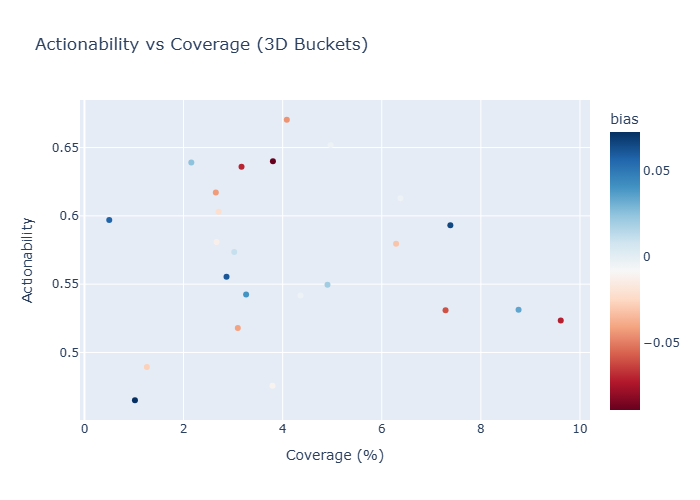

,session,trend_regime,vol_regime,bucket_key,bucket_level,count,coverage_pct,p_plus,p_minus,p_zero,p_nan,bias,actionability,prob_sum,low_count_flag
11,LONDON,CONSOLIDATION,LOW_VOL,LONDON|CONSOLIDATION|LOW_VOL,3D,4293,4.084060,0.313068,0.357326,0.329140,0.000466,-0.044258,0.670394,1.0,False
7,LONDON,UPTREND,LOW_VOL,LONDON|UPTREND|LOW_VOL,3D,5222,4.967845,0.324205,0.327652,0.345653,0.002489,-0.003447,0.651858,1.0,False
9,LONDON,DOWNTREND,LOW_VOL,LONDON|DOWNTREND|LOW_VOL,3D,3998,3.803417,0.275638,0.364432,0.358679,0.001251,-0.088794,0.640070,1.0,False
10,LONDON,CONSOLIDATION,HIGH_VOL,LONDON|CONSOLIDATION|HIGH_VOL,3D,2267,2.156665,0.332157,0.307014,0.359947,0.000882,0.025143,0.639171,1.0,False
6,LONDON,UPTREND,HIGH_VOL,LONDON|UPTREND|HIGH_VOL,3D,3332,3.169831,0.283013,0.352941,0.360444,0.003601,-0.069928,0.635954,1.0,False
8,LONDON,DOWNTREND,HIGH_VOL,LONDON|DOWNTREND|HIGH_VOL,3D,2787,2.651357,0.287406,0.329745,0.378902,0.003947,-0.042339,0.617151,1.0,False
5,ASIA,CONSOLIDATION,LOW_VOL,ASIA|CONSOLIDATION|LOW_VOL,3D,6702,6.375813,0.304834,0.308117,0.385258,0.001791,-0.003283,0.612951,1.0,False
17,NY,CONSOLIDATION,LOW_VOL,NY|CONSOLIDATION|LOW_VOL,3D,2846,2.707485,0.290583,0.312368,0.394238,0.002811,-0.021785,0.602952,1.0,False
22,OTHER,CONSOLIDATION,HIGH_VOL,OTHER|CONSOLIDATION|HIGH_VOL,3D,526,0.500400,0.326996,0.269962,0.403042,0.000000,0.057034,0.596958,1.0,False
1,ASIA,UPTREND,LOW_VOL,ASIA|UPTREND|LOW_VOL,3D,7762,7.384223,0.329425,0.263721,0.406596,0.000258,0.065705,0.593146,1.0,False


In [12]:
if "px" not in globals():
    import plotly.express as px
if "profile_3d" not in globals():
    raise RuntimeError("Run label-profile cells first (profile_3d is missing).")

LOW_COUNT_THRESHOLD = max(30, int(len(sol) * 0.002))

act_tbl = profile_3d.copy()
act_tbl["low_count_flag"] = act_tbl["count"] < LOW_COUNT_THRESHOLD

fig = px.scatter(
    act_tbl,
    x="coverage_pct",
    y="actionability",
    color="bias",
    hover_data=["bucket_key", "count", "p_plus", "p_minus", "p_zero", "p_nan", "low_count_flag"],
    title="Actionability vs Coverage (3D Buckets)",
    color_continuous_scale="RdBu",
)
fig.update_layout(xaxis_title="Coverage (%)", yaxis_title="Actionability")
fig.show()

act_tbl.sort_values(["actionability", "coverage_pct"], ascending=[False, False]).head(24)


---

## E. Temporal Drift

A regime edge is only useful if it persists over time. This section checks:

1. **Regime distribution drift** - Do the proportions of UPTREND/DOWNTREND/CONSOLIDATION (and other dimensions) stay stable month-to-month, or do they shift dramatically? Large shifts mean the market's character is changing.
2. **Bias drift for top buckets** - For the highest-coverage and highest-bias 3D buckets, track monthly directional bias. A bucket that flips sign frequently is unreliable regardless of its aggregate statistics.

C:\Users\a.pattichis\AppData\Local\Temp\ipykernel_52632\2065646821.py:123: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



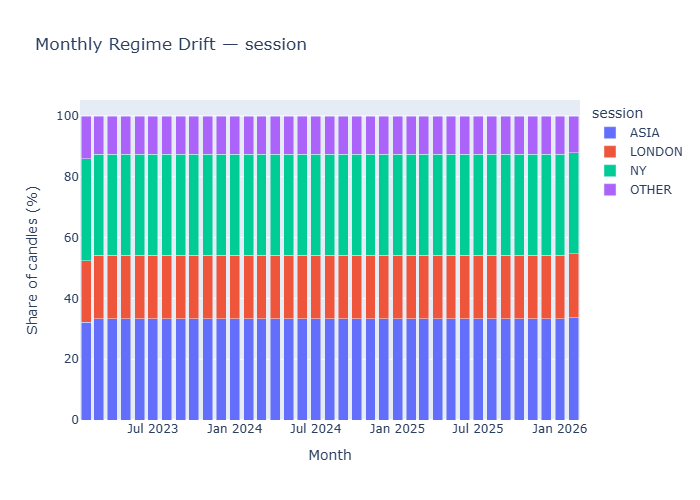

C:\Users\a.pattichis\AppData\Local\Temp\ipykernel_52632\2065646821.py:123: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



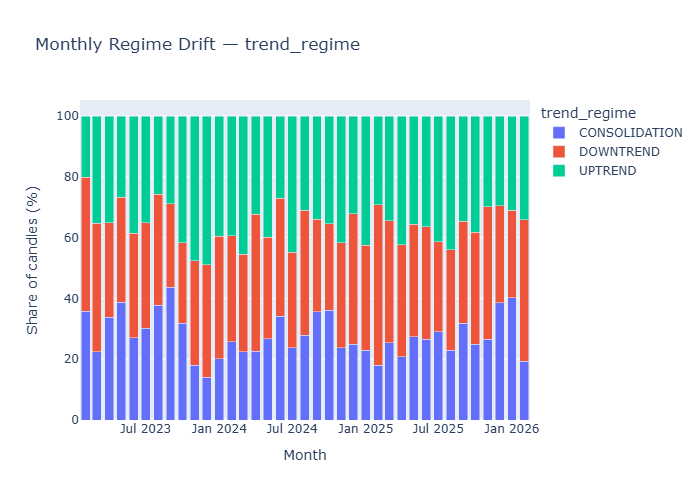

C:\Users\a.pattichis\AppData\Local\Temp\ipykernel_52632\2065646821.py:123: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



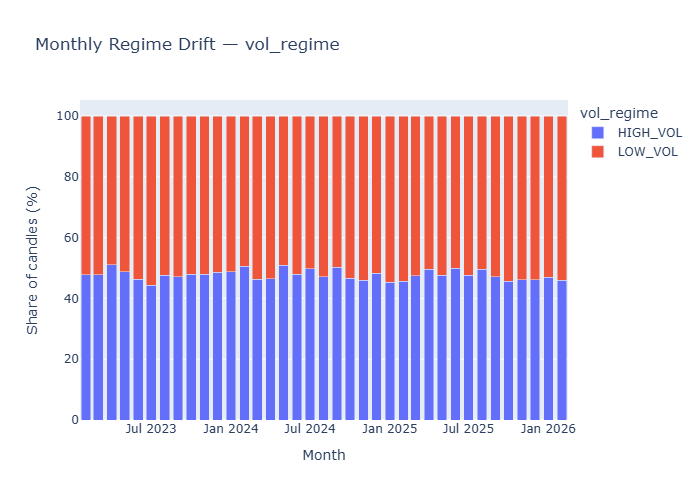

In [13]:
if "px" not in globals():
    import plotly.express as px
if "monthly_regime_drift" not in globals() or "sol" not in globals():
    raise RuntimeError("Run setup/helper cells first (monthly_regime_drift + sol).")

for col in ["session", "trend_regime", "vol_regime"]:
    drift = monthly_regime_drift(sol, col)
    fig = px.bar(
        drift,
        x="month",
        y="pct",
        color=col,
        barmode="stack",
        title=f"Monthly Regime Drift — {col}",
    )
    fig.update_layout(yaxis_title="Share of candles (%)", xaxis_title="Month")
    fig.show()


C:\Users\a.pattichis\AppData\Local\Temp\ipykernel_52632\3494610349.py:13: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



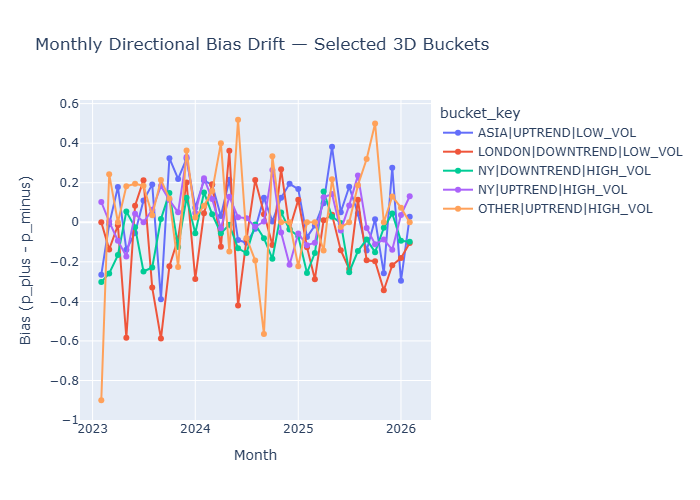

,month,bucket_key,bias
0,2023-02,ASIA|UPTREND|LOW_VOL,-0.264706
1,2023-02,LONDON|DOWNTREND|LOW_VOL,0.000000
2,2023-02,NY|DOWNTREND|HIGH_VOL,-0.302326
3,2023-02,NY|UPTREND|HIGH_VOL,0.102564
4,2023-02,OTHER|UPTREND|HIGH_VOL,-0.900000
...,...,...,...
180,2026-02,ASIA|UPTREND|LOW_VOL,0.027778
181,2026-02,LONDON|DOWNTREND|LOW_VOL,-0.105263
182,2026-02,NY|DOWNTREND|HIGH_VOL,-0.098039
183,2026-02,NY|UPTREND|HIGH_VOL,0.131737


In [14]:
if "px" not in globals():
    import plotly.express as px
required = ["profile_3d", "bucket_key_from_dims", "sol"]
missing = [x for x in required if x not in globals()]
if missing:
    raise RuntimeError(f"Run prerequisite cells first. Missing: {missing}")

top_by_coverage = profile_3d.nlargest(3, "coverage_pct")["bucket_key"].tolist()
top_by_abs_bias = profile_3d.assign(abs_bias=profile_3d["bias"].abs()).nlargest(3, "abs_bias")["bucket_key"].tolist()
selected_keys = list(dict.fromkeys(top_by_coverage + top_by_abs_bias))

tmp = sol.copy()
tmp["month"] = tmp.index.to_period("M").astype(str)
tmp["bucket_key"] = bucket_key_from_dims(tmp, ["session", "trend_regime", "vol_regime"])

monthly_bias = (
    tmp[tmp["bucket_key"].isin(selected_keys)]
    .groupby(["month", "bucket_key"])["tbm_label"]
    .apply(lambda s: (s == 1).mean() - (s == -1).mean())
    .rename("bias")
    .reset_index()
)

fig = px.line(
    monthly_bias,
    x="month",
    y="bias",
    color="bucket_key",
    markers=True,
    title="Monthly Directional Bias Drift — Selected 3D Buckets",
)
fig.update_layout(yaxis_title="Bias (p_plus - p_minus)", xaxis_title="Month")
fig.show()

monthly_bias


---

## F. Validation and Consolidated Findings

Automated consistency checks to catch pipeline bugs or data corruption:

1. Schema, index, and label integrity (via `validate_state_matrix`)
2. Coverage counts sum to total rows at every grouping level
3. Label probabilities (p_plus + p_minus + p_zero + p_nan) sum to 1.0 in every bucket
4. Monthly drift computation returns non-empty results
5. All 24 expected 3D buckets are populated (no zero-count gaps)

The **findings table** consolidates all 1D, 2D, and 3D bucket profiles with automated commentary flagging the best candidates, weak edges, and low-sample warnings.

In [15]:
# 1) Schema test + 2) Index test + 3) Label integrity test
_ = validate_state_matrix(sol)

# 4) Coverage consistency test for grouped buckets
for dims in [["session"], ["session", "trend_regime"], ["session", "trend_regime", "vol_regime"]]:
    ct = coverage_table(sol, dims)
    assert int(ct["count"].sum()) == len(sol), f"Coverage count mismatch for {dims}"

# 5) Probability consistency test
for prof, name in [
    (profile_1d["session"], "1D session"),
    (profile_1d["trend_regime"], "1D trend"),
    (profile_1d["vol_regime"], "1D vol"),
    (profile_3d, "3D"),
]:
    assert np.allclose(prof["prob_sum"].values, 1.0, atol=1e-8), f"Probability sum mismatch in {name}"

# 6) Drift section test
drift_test = monthly_regime_drift(sol, "session")
assert len(drift_test) > 0, "Monthly drift computation returned empty output"

# 7) Empty bucket safety check
all_3d = pd.MultiIndex.from_product([SESSION_ORDER, TREND_ORDER, VOL_ORDER], names=["session", "trend_regime", "vol_regime"])
observed = profile_3d.set_index(["session", "trend_regime", "vol_regime"]) ["count"]
reindexed = observed.reindex(all_3d, fill_value=0)
print("Validation checks passed.")
print(f"3D buckets with zero observed candles: {(reindexed == 0).sum()}")
print(f"Low count threshold used for warnings: {LOW_COUNT_THRESHOLD}")


Validation checks passed.
3D buckets with zero observed candles: 0
Low count threshold used for warnings: 210


C:\Users\a.pattichis\AppData\Local\Temp\ipykernel_52632\2065646821.py:123: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



In [16]:
findings = build_findings_table(
    profile_1d=pd.concat(profile_1d.values(), ignore_index=True),
    profile_2d=pd.concat(profile_2d.values(), ignore_index=True),
    profile_3d=profile_3d,
    low_count_threshold=LOW_COUNT_THRESHOLD,
)

findings.head(60)


,bucket_level,bucket_key,count,coverage_pct,bias,actionability,p_plus,p_minus,p_zero,p_nan,low_count_flag,comment
0,1D,LOW_VOL,54969,52.293657,-0.008769,0.583565,0.287398,0.296167,0.415234,0.001201,False,Neutral edge: weak directional skew.
1,1D,HIGH_VOL,50147,47.706343,-0.013919,0.556364,0.271223,0.285142,0.442519,0.001117,False,Neutral edge: weak directional skew.
2,1D,UPTREND,38195,36.336048,0.028407,0.572981,0.300694,0.272287,0.426103,0.000916,False,Potentially useful; validate with strategy-spe...
3,1D,DOWNTREND,37698,35.863237,-0.049684,0.539737,0.245026,0.294711,0.459388,0.000875,False,Potentially useful; validate with strategy-spe...
4,1D,ASIA,35040,33.334602,0.004424,0.568408,0.286416,0.281992,0.431136,0.000457,False,Neutral edge: weak directional skew.
5,1D,NY,35037,33.331748,-0.017467,0.544796,0.263664,0.281131,0.453806,0.001399,False,Neutral edge: weak directional skew.
6,1D,CONSOLIDATION,29223,27.800715,-0.013414,0.607261,0.296924,0.310338,0.390891,0.001848,False,Neutral edge: weak directional skew.
7,1D,LONDON,21899,20.833175,-0.039134,0.645189,0.303028,0.342162,0.352756,0.002055,False,Potentially useful; validate with strategy-spe...
8,1D,OTHER,13140,12.500476,0.010198,0.520852,0.265525,0.255327,0.478234,0.000913,False,Neutral edge: weak directional skew.
9,2D,NY|HIGH_VOL,25924,24.662278,-0.023183,0.540542,0.258679,0.281862,0.458301,0.001157,False,Potentially useful; validate with strategy-spe...


---

### How to Read the Findings Table

Each row is a regime bucket scored on three axes:

| Metric | What it tells you |
|--------|-------------------|
| **coverage_pct** | Sample size as % of total candles - higher is more reliable |
| **bias** | Directional skew - positive favors longs, negative favors shorts |
| **actionability** | How often the bucket produces a tradeable outcome (not timeout/whipsaw) |

**Automated commentary rules:**
- "Good candidate regime" - |bias| >= 0.08, actionability >= 0.50, coverage >= 3%
- "Neutral edge" - |bias| < 0.02 regardless of other metrics
- "Avoid/uncertain" - actionability < 0.25 (mostly timeouts)
- "Uncertain: low sample" - below the low-count threshold (0.2% of total rows)

Buckets that look good here should be validated in the temporal drift section (Section E) to confirm the edge is stable, then tested with actual strategy-specific backtests.